# Task 7

In [10]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Load possible targets trajectory
q_1 = np.load("Data/target_1.npy")  
q_2 = np.load("Data/target_2.npy")  
q_1 = q_1.T
q_2 = q_2.T

T = q_1.shape[0]


In [12]:
# Values of rho, p_1 and p_2
rho = 0.1
p1 = 0.6
p2= 0.4

# Define A, B, E matrices
A = np.array([
    [1, 0, 0.1, 0],
    [0, 1, 0, 0.1], 
    [0, 0, 0.8, 0],
    [0, 0, 0, 0.8]
    ])

B = np.array([
    [0, 0],
    [0, 0],
    [0.1, 0],
    [0, 0.1]
    ])

E = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
    ])

# Define x_initial vector
x_initial = np.array([0.5, 0, 1, -1])


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


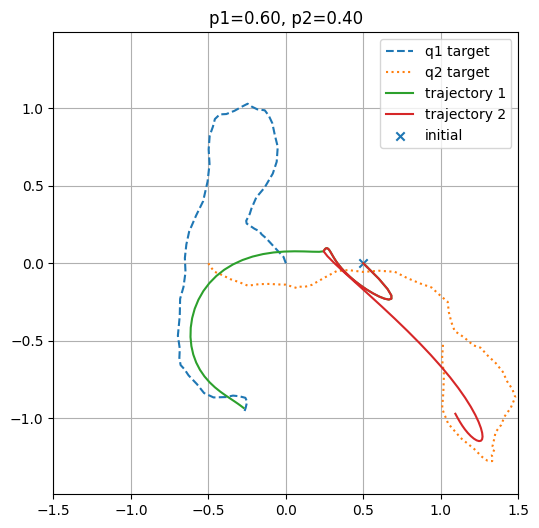

rho=0.1 | TE1=33.5750 | CE1=93.7766 | TE2=28.9040 | CE2=129.1059


In [13]:
TE_1_values = []
TE_2_values = []
CE_1_values = []
CE_2_values = []
results = []


# Variables
# Define optimization variables
x_1 = cp.Variable((T, 4))   # State variable for trajectory 1
u_1 = cp.Variable((T-1, 2)) # Control variable for trajectory 1
x_2 = cp.Variable((T, 4))   # State variable for trajectory 2
u_2 = cp.Variable((T-1, 2)) # Control variable for trajectory 2  

# Constraints
constraints = [x_1[0, :] == x_initial]
constraints += [x_2[0, :] == x_initial]
for t in range(T-1):
    constraints += [x_1[t+1, :] == A @ x_1[t, :] + B @ u_1[t, :]]
    constraints += [x_2[t+1, :] == A @ x_2[t, :] + B @ u_2[t, :]]

    if t < 25:
        constraints += [x_1[t, :] == x_2[t, :]]
        constraints += [u_1[t, :] == u_2[t, :]]

# Objective
TE_1 = cp.sum([cp.norm(E @ x_1[t, :].T - q_1[t, :].T, 2) for t in range(T)])
TE_2 = cp.sum([cp.norm(E @ x_2[t, :].T - q_2[t, :].T, 2) for t in range(T)])
CE_1 = cp.norm(u_1, "fro")**2
CE_2 = cp.norm(u_2, "fro")**2
objective = cp.Minimize(p1 * (TE_1 + rho * CE_1) + p2 * (TE_2 + rho * CE_2))

# Solve problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Extract results
x_1_val = x_1.value
x_2_val = x_2.value
u_1_val = u_1.value
u_2_val = u_2.value

TE_1_values.append(TE_1.value)
CE_1_values.append(CE_1.value)
TE_2_values.append(TE_2.value)
CE_2_values.append(CE_2.value)


# Plot trajectory vs target
traj1 = (E @ x_1_val.T).T  # shape (T, 2)
traj2 = (E @ x_2_val.T).T  # shape (T, 2)

plt.figure(figsize=(6,6))
plt.plot(q_1[:,0], q_1[:,1], '--', label='q1 target')
plt.plot(q_2[:,0], q_2[:,1], ':', label='q2 target')
plt.plot(traj1[:,0], traj1[:,1], label='trajectory 1')
plt.plot(traj2[:,0], traj2[:,1], label='trajectory 2')
plt.scatter([x_initial[0]], [x_initial[1]], marker='x', label='initial')
plt.title(f"p1={p1:.2f}, p2={p2:.2f}")
plt.legend()
plt.axis('equal')
plt.grid(True)
# Set plot limits manually
plt.xlim(-1.5, 1.5)   # adjust these as needed
plt.ylim(-1.5, 1.5)
plt.show()

print(f"rho={rho} | TE1={TE_1.value:.4f} | CE1={CE_1.value:.4f} | TE2={TE_2.value:.4f} | CE2={CE_2.value:.4f}")
